数据集下载：

cd ~/Downloads

mkdir jena_climate

cd jena_climate

axel -c  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

unzip jena_climate_2009_2016.csv.zip

In [1]:
# 　观察耶拿天气数据集的数据
import os
data_dir = '/home/fc/Downloads/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [2]:
# 解析数据
import numpy as np
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

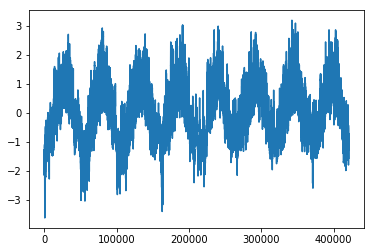

In [9]:
# 绘制温度时间序列
from matplotlib import pyplot as plt
%matplotlib inline

temp = float_data[:, 1] # 温度（单位：摄氏度）
plt.plot(range(len(temp)), temp)

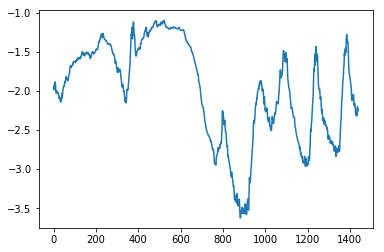

In [10]:
# 绘制前 10 天的温度时间序列
plt.plot(range(1440), temp[:1440])


In [5]:
#准备数据
# 数据标准化
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [7]:
# 　生成时间序列样本及其目标的生成器
def generator(data, lookback, delay, min_index, max_index,
    shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
            min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [13]:
# 准备训练生成器、验证生成器和测试生成器
lookback = 1440
step = 6
delay = 144
batch_size = 128
train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)
val_steps = (300000 - 200001 - lookback) //batch_size
test_steps = (len(float_data) - 300001 - lookback) //batch_size 

In [16]:
# 　计算符合常识的基准方法的 MAE
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
evaluate_naive_method()

0.289735972991


In [17]:
# 将 MAE 转换成摄氏温度误差
celsius_mae = 0.29 * std[1]

In [19]:
# 　训练并评估一个密集连接模型
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
 steps_per_epoch=500,
 epochs=20,
 validation_data=val_gen,
 validation_steps=val_steps)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
500/500 [==============================] - 14s 28ms/step - loss: 1.4025 - val_loss: 0.6556
Epoch 2/20
500/500 [==============================] - 13s 27ms/step - loss: 0.4543 - val_loss: 0.3261
Epoch 3/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2953 - val_loss: 0.3204
Epoch 4/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2663 - val_loss: 0.3407
Epoch 5/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2520 - val_loss: 0.3388
Epoch 6/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2412 - val_loss: 0.3296
Epoch 7/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2350 - val_loss: 0.3150
Epoch 8/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2302 - val_loss: 0.3378
Epoch 9/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2237 - val_loss: 0.3655
Epoch 10/20
500/500 [=============

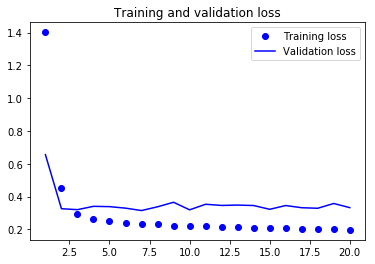

In [20]:
# 绘制结果
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()